In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
from scipy.optimize import curve_fit
%matplotlib inline

In [86]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, vertices, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    AllLines = []
    MinSlope = 0.2
    MaxSlope = 2
    SlopeThd = 0.05

    for pltline in lines:
        for x1,y1,x2,y2 in pltline:
            #plt.plot([x1, x2], [y1, y2])
            AllLines.extend([(y2-y1)/(x2-x1)])
    LinePos = [i for i in AllLines if i > 0 and abs(i) > MinSlope and abs(i) < MaxSlope]
    LineNeg = [i for i in AllLines if i <= 0 and abs(i) > MinSlope and abs(i) < MaxSlope]
    
    if not len(LineNeg):
        NegLines = []
    else:
        LineAbsNeg = sum(LineNeg)/len(LineNeg)
        LineNegLim = [i for i in LineNeg if abs(i-LineAbsNeg) < SlopeThd]
        NegLines = [lines[AllLines.index(i)] for i in LineNegLim]
    
    if not len(LinePos):
        PosLines = []
    else:
        LineAbsPos = sum(LinePos)/len(LinePos)
        LinePosLim = [i for i in LinePos if abs(i-LineAbsPos) < SlopeThd]
        PosLines = [lines[AllLines.index(i)] for i in LinePosLim]
        
    xCurveDataNeg = np.array([])
    yCurveDataNeg = np.array([])
    if len(NegLines):
        for pltline in NegLines:
            for x1,y1,x2,y2 in pltline:
                plt.plot([x1, x2], [y1, y2],'*b')
                xCurveDataNeg = np.concatenate((xCurveDataNeg,np.array([x1, x2])))
                yCurveDataNeg = np.concatenate((yCurveDataNeg,np.array([y1, y2])))
        xLimNeg = image.shape[1]/2
        SearchIndexNeg = (xCurveDataNeg < xLimNeg)
        yCurveDataNeg = yCurveDataNeg[SearchIndexNeg]
        xCurveDataNeg = xCurveDataNeg[SearchIndexNeg]
        
    xCurveDataPos = np.array([])
    yCurveDataPos = np.array([])
    if len(PosLines):
        for pltline in PosLines:
            for x1,y1,x2,y2 in pltline:
                plt.plot([x1, x2], [y1, y2],'*r')
                xCurveDataPos = np.concatenate((xCurveDataPos,np.array([x1, x2])))
                yCurveDataPos = np.concatenate((yCurveDataPos,np.array([y1, y2])))
        xLimPos = img.shape[1]/2
        SearchIndexPos = (xCurveDataPos > xLimPos)
        yCurveDataPos = yCurveDataPos[SearchIndexPos]
        xCurveDataPos = xCurveDataPos[SearchIndexPos]
    def CurveFitFunc(x, a, b):
        return a * x + b
    def CurveFitFuncInv(y, a, b):
        return (y-b) / a
    
    if not yCurveDataNeg.any():
        LineNeg = []
    else:
        popt, pcov = curve_fit(CurveFitFunc, xCurveDataNeg, yCurveDataNeg)
        yLimNeg = vertices[0][1][1]
        yMax = img.shape[0]
        xStartNeg = CurveFitFuncInv(yMax, *popt)
        xEndNeg = CurveFitFuncInv(yLimNeg, *popt)
        LineNeg = [xStartNeg,yMax,xEndNeg,yLimNeg]
        LineNeg = [int(i) for i in LineNeg]
    plt.plot(xCurveDataNeg, CurveFitFunc(xCurveDataNeg, *popt), 'b-',)
    
    if not yCurveDataPos.any():
        LinePos = [] 
    else:
        popt, pcov = curve_fit(CurveFitFunc, xCurveDataPos, yCurveDataPos)
        yLimPos = vertices[0][2][1]
        yMax = img.shape[0]
        xStartPos = CurveFitFuncInv(yMax, *popt)
        xEndPos = CurveFitFuncInv(yLimPos, *popt)
        LinePos = [xStartPos,yMax,xEndPos,yLimPos]
        LinePos = [int(i) for i in LinePos]
    plt.plot(xCurveDataPos, CurveFitFunc(xCurveDataPos, *popt), 'r-',)
    LinesFit = np.array([[LineNeg],[LinePos]])
    plt.show()
    for pltline in LinesFit:
        for x1,y1,x2,y2 in pltline:
            plt.plot([x1, x2], [y1, y2],'k')
    
    if LinePos and LineNeg:
        for line in LinesFit:
            for x1,y1,x2,y2 in line:
                cv2.line(img,(x1,y1),(x2,y2),color,thickness)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, vertices):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, vertices)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

In [87]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    gray = grayscale(image)
    #plt.imshow(gray, cmap='gray')
    plt.show()

    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)
    #plt.imshow(blur_gray, cmap='gray')
    plt.show()

    low_threshold = 50
    high_threshold = 150
    masked_edges = canny(blur_gray, low_threshold, high_threshold)
    #plt.imshow(masked_edges, cmap='gray')
    plt.show()

    imshape = image.shape
    xUpperLeft = 470
    xUpperRight = 490
    yUpper = 315
    vertices = np.array([[(0,imshape[0]),(xUpperLeft, yUpper), (xUpperRight, yUpper), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_image = region_of_interest(masked_edges, vertices)
    #plt.imshow(masked_image, cmap='gray')
    plt.show()

    rho = 2
    theta = 1*np.pi/180
    threshold = 15
    min_line_len = 20
    max_line_gap = 25
    line_img = hough_lines(masked_image, rho, theta, threshold, min_line_len, max_line_gap, vertices)
    #plt.imshow(line_img)
    plt.show()

    color_edges = np.dstack((masked_edges, masked_edges, masked_edges))
    combox = cv2.addWeighted(color_edges, 0.8, line_img, 1, 0) 
    #plt.imshow(combox)
    plt.show()

    result = weighted_img(line_img, image, α=0.8, β=1., γ=0.)
    #plt.imshow(result)
    plt.show()
    return result 

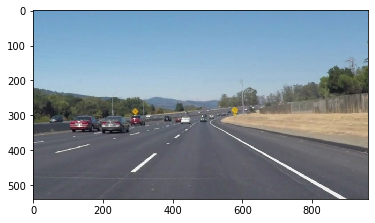

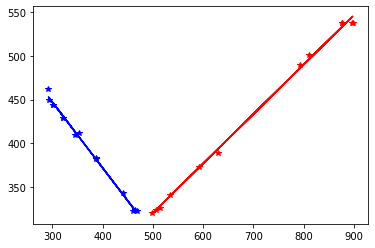

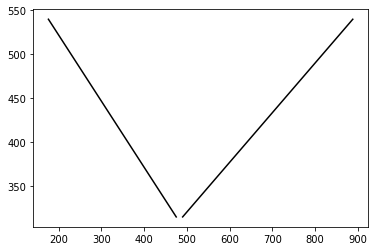

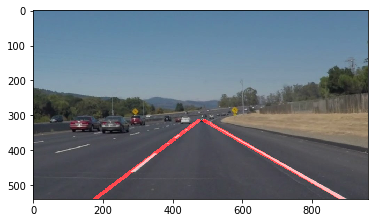

In [88]:
image = mpimg.imread('test_images/solidWhiteCurve.jpg')
#image = mpimg.imread('test_images/solidWhiteRight.jpg')
#image = mpimg.imread('test_images/solidYellowCurve.jpg')
#image = mpimg.imread('test_images/solidYellowCurve2.jpg')
#image = mpimg.imread('test_images/solidYellowLeft.jpg')
#image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
plt.imshow(image)
plt.show()
imageOut = process_image(image)
plt.imshow(imageOut)
#imageOutCV2 = cv2.cvtColor(imageOut, cv2.COLOR_BGR2RGB)
#cv2.imshow('image',imageOutCV2)
#cv2.waitKey(0)

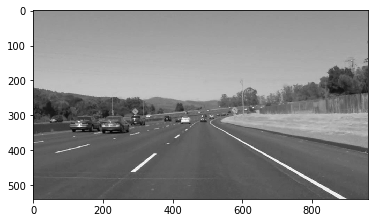

In [66]:
# NOTE: The output you return should be a color image (3 channel) for processing video below
# TODO: put your pipeline here,
# you should return the final output (image where lines are drawn on lanes)
image = mpimg.imread('test_images/solidWhiteCurve.jpg')
#image = cv2.resize(image, (480, 270), interpolation = cv2.INTER_CUBIC)

cv2.imwrite('examples/Initial_Image.jpg', cv2.cvtColor(cv2.resize(image, (480, 270), interpolation = cv2.INTER_CUBIC), cv2.COLOR_RGB2BGR))

gray = grayscale(image)
plt.imshow(gray, cmap='gray')
plt.show()

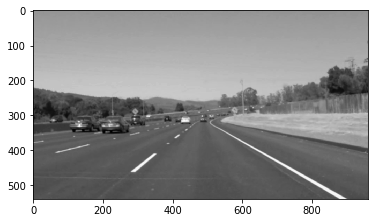

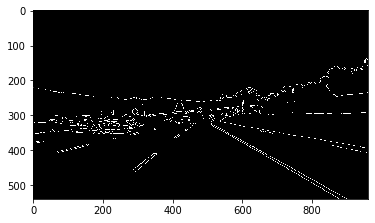

True

In [67]:
kernel_size = 5
blur_gray = gaussian_blur(gray, kernel_size)
plt.imshow(blur_gray, cmap='gray')
plt.show()
cv2.imwrite('examples/Grayscale_Image.jpg',  cv2.resize(blur_gray, (480, 270), interpolation = cv2.INTER_CUBIC))

low_threshold = 50
high_threshold = 150
masked_edges = canny(blur_gray, low_threshold, high_threshold)
plt.imshow(masked_edges, cmap='gray')
plt.show()
cv2.imwrite('examples/masked_edges.jpg', cv2.resize(masked_edges, (480, 270), interpolation = cv2.INTER_CUBIC))

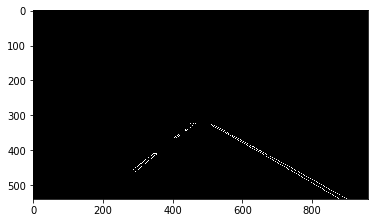

True

In [68]:
imshape = image.shape
xUpperLeft = 470
xUpperRight = 490
yUpper = 315
vertices = np.array([[(0,imshape[0]),(xUpperLeft, yUpper), (xUpperRight, yUpper), (imshape[1],imshape[0])]], dtype=np.int32)
masked_image = region_of_interest(masked_edges, vertices)
plt.imshow(masked_image, cmap='gray')
plt.show()
cv2.imwrite('examples/region.jpg', cv2.resize(masked_image, (480, 270), interpolation = cv2.INTER_CUBIC))

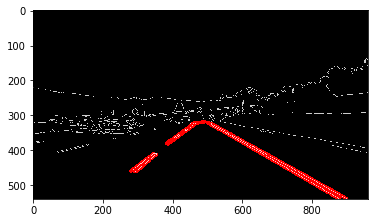

True

In [73]:
rho = 2
theta = 1*np.pi/180
threshold = 15
min_line_len = 20
max_line_gap = 25
lines = cv2.HoughLinesP(masked_image, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
#line_img = hough_lines(masked_image, rho, theta, threshold, min_line_len, max_line_gap, vertices)
line_img = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_img,(x1,y1),(x2,y2),[255,0,0],10)

color_edges = np.dstack((masked_edges, masked_edges, masked_edges))
combox = cv2.addWeighted(color_edges, 0.8, line_img, 1, 0) 
plt.imshow(combox)
plt.show()

cv2.imwrite('examples/hough_image.jpg', cv2.resize(combox, (480, 270), interpolation = cv2.INTER_CUBIC))

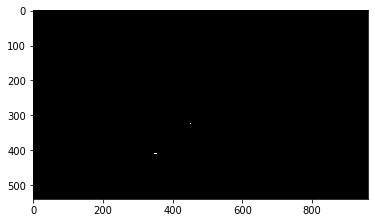

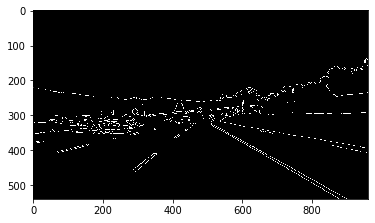

In [64]:
gray = grayscale(image)
kernel_size = 5
blur_gray = gaussian_blur(gray, kernel_size)
low_threshold = 50
high_threshold = 150
masked_edges = canny(blur_gray, low_threshold, high_threshold)
imshape = image.shape
xUpperLeft = 470
xUpperRight = 490
yUpper = 315
vertices = np.array([[(0,imshape[0]),(xUpperLeft, yUpper), (xUpperRight, yUpper), (imshape[1],imshape[0])]], dtype=np.int32)
masked_image = region_of_interest(masked_edges, vertices)
rho = 2
theta = 1*np.pi/180
threshold = 15
min_line_len = 20
max_line_gap = 25
masked_imageX = masked_image
lines = cv2.HoughLinesP(masked_imageX, rho, theta, threshold, np.array([]), min_line_len, max_line_gap)
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(masked_imageX,(x1,y1),(x2,y2),[0,0,255],2)
#cv2.imshow('image',masked_imageX)
#cv2.waitKey(0)
plt.imshow(masked_image, cmap='gray')
plt.show()
plt.imshow(masked_edges, cmap='gray')

In [8]:
cv2.imwrite('examples/Grayscale_Image.jpg', cv2.resize(blur_gray, (480, 270), interpolation = cv2.INTER_CUBIC))
cv2.imwrite('examples/Initial_Image.jpg', cv2.cvtColor(cv2.resize(image, (480, 270), interpolation = cv2.INTER_CUBIC), cv2.COLOR_RGB2BGR))
cv2.imwrite('examples/masked_edges.jpg', cv2.resize(masked_edges, (480, 270), interpolation = cv2.INTER_CUBIC))
cv2.imwrite('examples/region.jpg', cv2.resize(masked_image, (480, 270), interpolation = cv2.INTER_CUBIC))

True

In [6]:
import os
from matplotlib import pyplot as plt

ReadDirectory = 'test_images/'
SaveDirectory = 'test_images_output/'
for file in os.listdir(ReadDirectory): 
    image = mpimg.imread(ReadDirectory+file)
    imageOut = process_image(image) 
    cv2.imwrite(SaveDirectory+file, cv2.cvtColor(imageOut, cv2.COLOR_BGR2RGB))

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
from scipy.optimize import curve_fit
from IPython.core.debugger import set_trace

cap = cv2.VideoCapture('test_videos/solidWhiteRight.mp4')
#cap = cv2.VideoCapture('test_videos/solidYellowLeft.mp4')
#cap = cv2.VideoCapture('test_videos/challenge.mp4')
vid_cod = cv2.VideoWriter_fourcc(*'XVID')
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret: 
        UpdatedPicture = process_image(frame)   
        cv2.imshow('frame',UpdatedPicture)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()